Sigma_u at t=10:
[[ 9.35278649  0.          0.        ]
 [ 0.         -4.69731889  0.        ]
 [ 0.          0.         -4.69731889]]


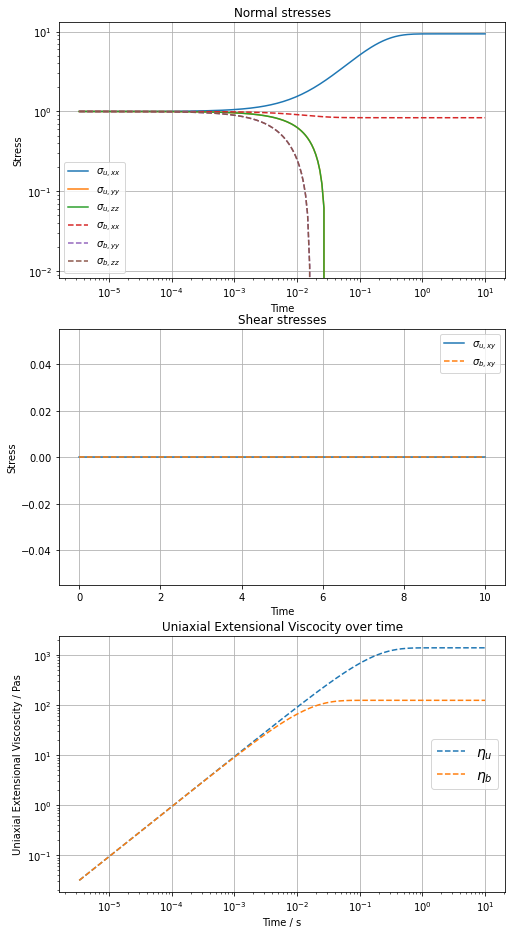

In [11]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# Define parameters
kB = 1.0
T = 1.0

tau_u = 0.149160
tau_b = 0.013278
k_plus = 0.010000
k_minus = 0.010000
n = 3149.598944

# tau_u = 1.0
# tau_b = 1.0
# k_plus = 1.0
# k_minus = 1.0
# n = 1

#Amplitude = 0.1
#Frequency=1.253

StrainRate=0.01

# Peterlin function
def peterlin(sigma, L2=50.0):
    tr_sigma = np.trace(sigma)
    return (L2 - 3.0) / (L2 - tr_sigma)

# Velocity gradient tensor (example: simple shear)
def grad_v(t):
    return 0.5*np.array([[2*StrainRate, 0.0, 0.0],
                         [0.0, -StrainRate, 0.0],
                         [0.0, 0.0, -StrainRate]])

# Upper-convected derivative
# ∇σ = dσ/dt - (σ·∇v + (∇v)^T·σ)
def upper_convected(t, sigma, grad):
    return - (sigma @ grad + grad.T @ sigma)

# System of ODEs for sigma_u and sigma_b (both 3x3 -> flattened 18 variables)
def rhs(t, y):
    sigma_u = y[:9].reshape((3, 3))
    sigma_b = y[9:].reshape((3, 3))
    grad = grad_v(t)

    # Compute Peterlin factors
    # fP_u = peterlin(sigma_u)
    # fP_b = peterlin(sigma_b)
    fP_u = 1
    fP_b = 1

    # Eqn for sigma_u
    dsigma_u_dt = n * kB * T * ( grad + grad.T ) \
                   - ((1 + k_plus * tau_u) * fP_u * sigma_u \
                   + k_minus * tau_u * fP_b * sigma_b \
                   - tau_u * upper_convected(t, sigma_u, grad))/tau_u

    dsigma_b_dt = n * kB * T * ( grad + grad.T ) \
                   - ((1 + k_minus * tau_b) * fP_b * sigma_b \
                   + k_plus * tau_b * fP_u * sigma_u \
                   - tau_b * upper_convected(t, sigma_b, grad))/tau_b

    return np.concatenate([dsigma_u_dt.flatten(), dsigma_b_dt.flatten()])


# Initial conditions (identity tensors)
sigma_u0 = np.eye(3)
sigma_b0 = np.eye(3)
y0 = np.concatenate([sigma_u0.flatten(), sigma_b0.flatten()])


# Time span
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 3000000)


# Solve
sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, method='RK45')

#----------------------------------------
#Code below to extract only a set amount of solutions to make the graphs generate faster!
# Extract solutions
# Number of samples you want
n_samples = 200  # for example

# Get time array from the solution
t = sol.t
y=sol.y
mask = t > 0
t = t[mask]
y = y[:, mask]

# Create log-spaced sampling points between min and max of t
t_log = np.logspace(np.log10(t[0]), np.log10(t[-1]), n_samples)

# Interpolate solution at those points
from scipy.interpolate import interp1d

interp_func = interp1d(t, y, kind='linear', axis=1, fill_value="extrapolate")
y_log = interp_func(t_log)

# Recreate the sigma_u and sigma_b arrays
sigma_u_sol = y_log[:9, :].T.reshape(-1, 3, 3)
sigma_b_sol = y_log[9:, :].T.reshape(-1, 3, 3)
#----------------------------------------
#sigma_u_sol = sol.y[:9, :].T.reshape(-1, 3, 3)
#sigma_b_sol = sol.y[9:, :].T.reshape(-1, 3, 3)

# Example: print sigma_u at final time
print("Sigma_u at t=10:")
print(sigma_u_sol[-1])

# ---- Plotting ----
t = sol.t
t=t_log

fig, axs = plt.subplots(3, 1, figsize=(8, 16))

# Normal stresses (xx, yy, zz from both sigma_u and sigma_b)
axs[0].plot(t, sigma_u_sol[:, 0, 0], label=r"$\sigma_{u,xx}$")
axs[0].plot(t, sigma_u_sol[:, 1, 1], label=r"$\sigma_{u,yy}$")
axs[0].plot(t, sigma_u_sol[:, 2, 2], label=r"$\sigma_{u,zz}$")
axs[0].plot(t, sigma_b_sol[:, 0, 0], '--', label=r"$\sigma_{b,xx}$")
axs[0].plot(t, sigma_b_sol[:, 1, 1], '--', label=r"$\sigma_{b,yy}$")
axs[0].plot(t, sigma_b_sol[:, 2, 2], '--', label=r"$\sigma_{b,zz}$")
axs[0].set_title("Normal stresses")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Stress")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].legend()
axs[0].grid(True)

# Shear stresses (xy from both sigma_u and sigma_b, you can add yz, xz too)
axs[1].plot(t, sigma_u_sol[:, 0, 1], label=r"$\sigma_{u,xy}$")
#axs[1].plot(t, sigma_u_sol[:, 1, 0], label=r"$\sigma_{u,yx}$")
axs[1].plot(t, sigma_b_sol[:, 0, 1], '--', label=r"$\sigma_{b,xy}$")
#axs[1].plot(t, sigma_b_sol[:, 1, 0], '--', label=r"$\sigma_{b,yx}$")
#axs[1].plot(t, sigma_b_sol[:, 0, 1]+sigma_u_sol[:,0,1], '--', label="sigma total")
axs[1].set_title("Shear stresses")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Stress")
#axs[1].set_xscale("log")
#axs[1].set_yscale("log")
axs[1].legend()
axs[1].grid(True)
#plt.tight_layout()
#plt.show()

uniaxial_ext_visc_u = (sigma_u_sol[:, 0, 0] - sigma_u_sol[:, 1, 1])/StrainRate
uniaxial_ext_visc_b = (sigma_b_sol[:, 0, 0] - sigma_b_sol[:, 1, 1])/StrainRate

# --- New plot: Stress vs Strain ---
axs[2].plot(t, uniaxial_ext_visc_u, '--', label=r"$\eta_{u}$")
axs[2].plot(t, uniaxial_ext_visc_b, '--', label=r"$\eta_{b}$")
axs[2].set_xlabel("Time / s")
axs[2].set_ylabel("Uniaxial Extensional Viscoscity / Pas")
axs[2].set_title("Uniaxial Extensional Viscocity over time")
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].legend(fontsize=14, loc="center right")
axs[2].grid(True)
#fig.savefig("ext_graphs_1&2&3_first_try.png", dpi=300, bbox_inches="tight")

# --- Compute strain history ---
# gamma = (Amplitude / Frequency) * np.sin(Frequency * t)  # oscillatory strain
# gamma_dot = Amplitude * np.cos(Frequency * t)            # strain rate

# # --- New plot: Stress vs Strain ---
# plt.figure(figsize=(6,5))
# #plt.plot(gamma, sigma_u_sol[:, 0, 1], label=r"$\sigma_{u,xy}$ vs $\gamma$")
# #plt.plot(gamma, sigma_b_sol[:, 0, 1], '--', label=r"$\sigma_{b,xy}$ vs $\gamma$")
# plt.plot(gamma, sigma_u_sol[:, 0, 1]+sigma_b_sol[:, 0, 1], '--', label=r"$\sigma_{xy}$ vs $\gamma$")
# plt.xlabel("Shear strain $\gamma$")
# plt.ylabel("Shear stress")
# plt.title("Stress vs Strain")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()